This notebook creates the results and figures for "Strategies for Network GWAS Evaluated using Classroom Crowd Science".

In [1]:
from collections import namedtuple
import seaborn as sns
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import hypergeom, spearmanr
from textwrap import wrap

mpl.rcParams['pdf.fonttype'] = 42

# Function definitions

In [2]:
def load_gold_standards(path = '../data/raw/gold_standards'): 
    """Loads Gold standard gene lists"""
    
    Gold = namedtuple('Standard', ['sz_hugo', 'sz2', 'bip'])
    
    sz_hugo = read_column_file(os.path.join(path, 'SZ_hugo_genes_only.txt'))
    sz2 = read_gold_standard(os.path.join(path, 'scz2_gene_10k.txt'))
    bip = read_gold_standard(os.path.join(path, 'bip_gene_10k.txt'))
    
    return Gold(sz_hugo, sz2, bip)

def read_gold_standard(fn): 
    """Helper function to load gold standards as DataFrames"""
    df = pd.read_csv(fn, index_col=0, sep='\t')
    df.index = df['Gene']
    df_dict = df['TopSNP P-Value'].to_dict()
    
    return df_dict

def read_column_file(fn): 
    """Reads a single column file"""
    return pd.read_csv(fn, header=None).values.ravel()

def read_files(filesList, names=None, top=1000): 
    """Wrapper function to read a list of files"""
    if names is None: 
        names = [os.path.basename(f).split('.')[0].split('team')[1] for f in filesList]
    
    return dict(zip(names, [read_column_file(f)[:top] for f in filesList]))

In [3]:
def run_hypergeom(test, gold, top=100):
    """Performs hypergeometric test against a gold standard"""
    intersect = set(test).intersection(set(gold))
    
    score = len(intersect)
    M, n, N = 20000, len(gold), top
    
    pvalue = 1 - hypergeom.cdf(score, M, n, N)
    
    Hypergeom = namedtuple('Hypergeom', ['pvalue', 'n_intersect', 'common_items'])
    
    return Hypergeom(pvalue, score, intersect)

def check_significance(test, gold, threshold=0.05):
    """Compares with GWAS sginificance"""
    
    significant_gene_set = [k for k,v in gold.items() if v < threshold]
    
    return run_hypergeom(test, significant_gene_set, top=len(test))
    

In [4]:
def evaluate_all(top=100, 
    genes_lists_paths=["../data/teams_submissions/"], 
    gold_standard_path="../data/gold_standards"
): 
    """Wrapper function to evaluate all submitted gene lists"""
    
    genes_lists_map = {}
    for path in genes_lists_paths: 
        genes_lists_map.update(read_files(glob.glob(os.path.join(path, "*")), top=top))
    
    gwas = pd.Series(read_gold_standard(os.path.join(gold_standard_path, 'original_sz_gwas.txt')))
    gwas_genes = gwas.sort_values()[:top].index
    
    genes_lists_map['BL'] = gwas_genes
    
    GoldStandard = load_gold_standards(path=gold_standard_path)
    
    results_df = pd.DataFrame([], columns=['Literature Set', 'SZ GWAS', 'BIP GWAS', 'Literature p-value', 'SZ p-value', 'BIP p-value'])
    for name, team in genes_lists_map.items(): 
        sz = run_hypergeom(team, GoldStandard.sz_hugo)
        bip = check_significance(team, GoldStandard.bip, threshold=0.05/len(team))
        sz2 = check_significance(team, GoldStandard.sz2, threshold=0.05/len(team))

        results_df.loc[name] = [sz.n_intersect, sz2.n_intersect, bip.n_intersect, sz.pvalue, sz2.pvalue, bip.pvalue]
        
    return results_df

In [5]:
standings = evaluate_all(top=100)
standings = standings.sort_values(by='Literature Set', ascending=False)

In [6]:
standings

,Literature Set,SZ GWAS,BIP GWAS,Literature p-value,SZ p-value,BIP p-value
A,33.0,30.0,1.0,0.000000e+00,1.638107e-06,5.277686e-01
B,29.0,37.0,2.0,0.000000e+00,1.762380e-10,2.579407e-01
D,20.0,32.0,3.0,1.875200e-07,1.501731e-07,1.001465e-01
E,18.0,55.0,12.0,3.488472e-06,0.000000e+00,2.231890e-08
F,16.0,62.0,15.0,5.056406e-05,0.000000e+00,0.000000e+00
G,15.0,27.0,1.0,1.743231e-04,4.203179e-05,5.277686e-01
H,11.0,48.0,8.0,1.190759e-02,0.000000e+00,6.813184e-05
I,10.0,70.0,14.0,2.807507e-02,0.000000e+00,2.117874e-10
BL,9.0,71.0,16.0,6.068557e-02,0.000000e+00,0.000000e+00
C,8.0,69.0,12.0,1.197704e-01,0.000000e+00,2.231890e-08


# Figures

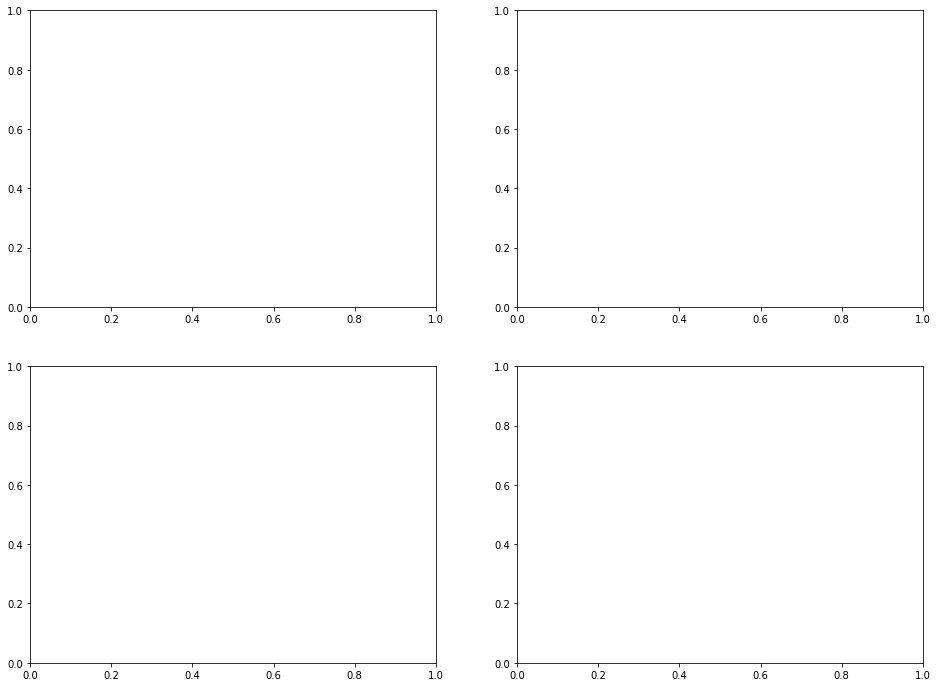

In [7]:
fig, axs = plt.subplots(2,2, figsize=(16, 12))
ax1, ax3 = axs[:, 0]
ax2, ax4 = axs[:, 1]

# Figure 2A

In [8]:
tmp = standings['Literature Set']
x = tmp.index
y = tmp.values

ax1.bar(np.arange(len(y)), y, color='#4178BC')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

_ = ax1.xaxis.set_ticks(np.arange(len(y)))
_ = ax1.set_xticklabels(x)
_ = ax1.set_xlabel('Teams')
_ = ax1.set_ylabel('Overlap with Schizophrenia Genes')

# Add stars for signifiance
for ind, i in enumerate(x): 
    if standings.loc[i, 'Literature p-value'] < 0.05: 
        ax1.text(ind, standings.loc[i, 'Literature Set'] + 0.5, '*', ha='center', fontsize=20)

# Figure 2B

In [9]:
tmp = standings[['SZ GWAS', 'BIP GWAS']]
tmp.columns = ['Schizophrenia GWAS', 'Bipolar GWAS']
tidy_df = tmp.reset_index().melt(id_vars=['index'])

team_order = standings.sort_values(by='SZ GWAS', ascending=False).index

g = sns.barplot(data=tidy_df, 
            x='index', 
            y='value', 
            hue='variable', 
            order=team_order, 
            palette = {'Schizophrenia GWAS': '#4178BC', 'Bipolar GWAS': '#37A862'}, 
            ax = ax2
)

sns.despine()

_ = ax2.set_xlabel('Teams')
_ = ax2.set_ylabel('Overlap with Validation GWAS')

# Add stars for signifiance
for ind, i in enumerate(team_order): 
    if standings.loc[i, 'SZ p-value'] < 0.05: 
        ax2.text(ind-0.21, standings.loc[i, 'SZ GWAS'] + 0.5, '*', ha='center', fontsize=20)
 
    if standings.loc[i, 'BIP p-value'] < 0.05: 
        ax2.text(ind + 0.17, standings.loc[i, 'BIP GWAS'] + 0.5, '*', ha='center', fontsize=20)    
        
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#fig.savefig('../figures/Figure_2B.pdf',bbox_inches="tight", transparent=True)

<Figure size 432x288 with 0 Axes>

# Figure 2C

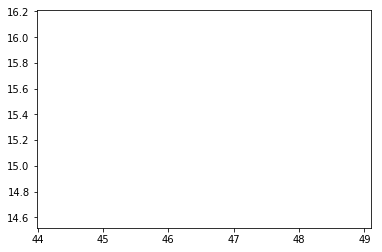

In [10]:
#sns.set_style('ticks')

#fig, ax3 = plt.subplots()
#fig.set_size_inches(12, 8)
#fig.tight_layout()
#sns.set(font_scale=2)

g = sns.regplot(data=standings, 
            y='Literature Set', 
            x='SZ GWAS', 
            fit_reg=False, 
            ci=None, 
            scatter_kws={"s":100, "color":'#4178BC'}, 
            ax=ax3, 
)

for ind, row in standings.iterrows(): 
    ax3.text(row['SZ GWAS'] + 0.85, row['Literature Set'] + 0.8, ind, fontsize=16)

ax3.set_ylabel('Overlap with Schizophrenia Genes')
ax3.set_xlabel('Overlap with Validation Schizophrenia GWAS')

stat = spearmanr(standings['Literature Set'], standings['SZ GWAS'])

ax3.text(0.05,0.95, r'$\rho$ = %s' % '{:4.2f}'.format(stat.correlation) + '\n' + 'p = %s' % '{:5.3f}'.format(stat.pvalue), 
        horizontalalignment='left', 
        verticalalignment='center', 
        transform=ax3.transAxes, 
        fontsize=16)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

#fig.savefig('../figures/Figure_2C.pdf', dpi=300, bbox_inches="tight", transparent=True)

# Figure 2D

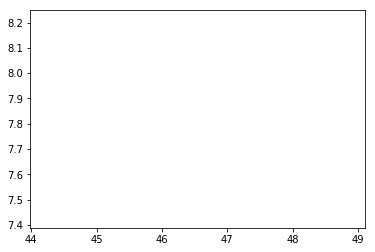

In [11]:
g = sns.regplot(data=standings, 
            y='BIP GWAS', 
            x='SZ GWAS', 
            fit_reg=False, 
            ci=None, 
            scatter_kws={"s":100, "color":'#4178BC'}, 
            ax=ax4, 
)

for ind, row in standings.iterrows(): 
    ax4.text(row['SZ GWAS'] + 0.5, row['BIP GWAS'] + 0.5, ind, fontsize=20)

ax4.set_ylabel('Overlap with Validation Bipolar GWAS')
ax4.set_xlabel('Overlap with Validation Schizophrenia GWAS')

stat = spearmanr(standings['BIP GWAS'], standings['SZ GWAS'])

ax4.text(0.05,0.95, r'$\rho$ = %s' % '{:4.2f}'.format(stat.correlation) + '\n' + 'p = %s' % '{:5.3f}'.format(stat.pvalue), 
        horizontalalignment='left', 
        verticalalignment='center', 
        transform=ax4.transAxes, 
        fontsize=16)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

#fig.savefig('../figures/Figure_2D.pdf', dpi=300, bbox_inches="tight", transparent=True)

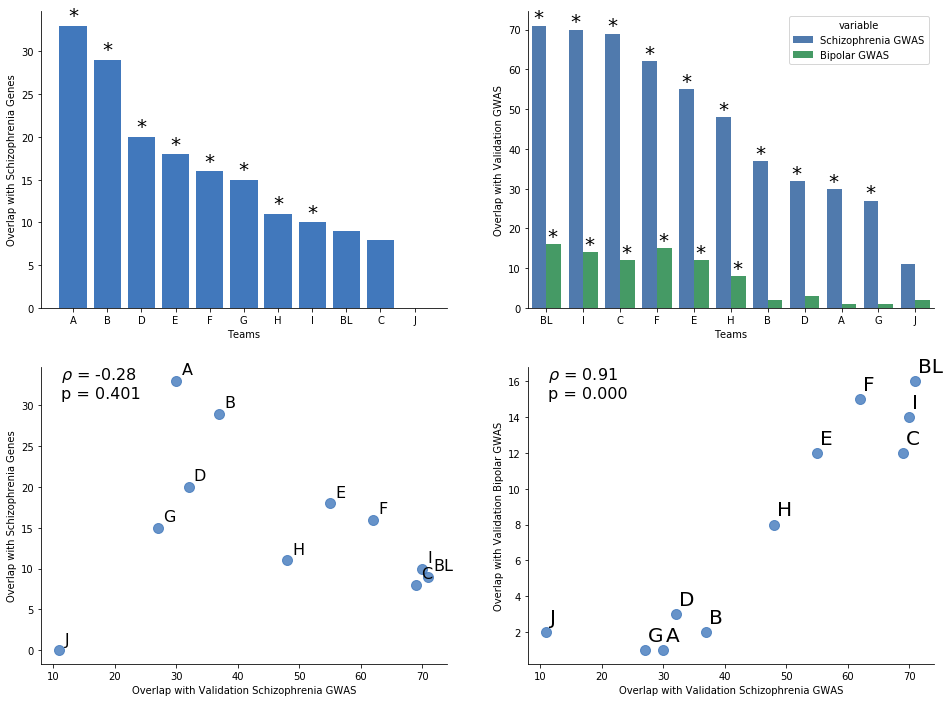

In [12]:
fig

In [13]:
fig.savefig('../figures/Figure_2.pdf', dpi=300, bbox_inches="tight", transparent=True)